In [146]:
from multidataset import MultiDataset
from multibodymodel import Net as Model
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from utils import accuracy
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#Parameters to change, can change model_type to 'best' or 'last'
use_jet_mass = True
N = 8
model_type = 'best' 
#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = 'models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_'+ model_type
#num of features
features = 3*N
if use_jet_mass:
    features+=2
else:
    features+=1

#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_mass)
testloader = DataLoader(test_set, shuffle=False, batch_size=512, num_workers=50, pin_memory=True, persistent_workers=True)
    
#loading model
model = Model(features).double().cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=26, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=0)
)

In [147]:
with torch.no_grad():
    for x,y in tqdm(testloader):
        x = x.cuda()
        y = .cuda()
        pred = model(x)
        top1, top5 = accuracy(pred, y, topk=(1024,2))
        test_top1_total += top1.item() * len(x)
        test_top5_total += top5.item() * len(x)

SyntaxError: invalid syntax (642797576.py, line 4)

In [148]:
def evaluate_model(model, test_loader):
   
    test_features, test_labels = next(iter(test_loader))
    #Find loss and accuracy
    crit = torch.nn.BCELoss()
    val_loss_total=0

    with torch.no_grad():
        for x,y in tqdm(test_loader):
            x = x.cuda()
            y = y.cuda()
            pred = model(x)
            loss = crit(pred, y)
            val_loss_total += loss.item()/len(x)
        acc = accuracy_score(model(test_features.cuda())[:,1].cpu().round(), test_labels[:,1].detach().numpy())
    print("Loss: "+str(val_loss_total))    
    print("Accuracy: "+str(acc))
    fpr, tpr, thresholds = roc_curve(
            test_labels[:,1].detach().numpy(), model(test_features.cuda())[:,1].cpu().ravel().detach().numpy())
    
    rej_at_30_marker  = None
    rej_at_50_marker  = None
    rej_at_80_marker  = None

    for i in range(len(fpr)):
        if(tpr[i] >= .30 and rej_at_30_marker is None):
            rej_at_30_marker = 1 / fpr[i]
            print("Background rejection at 30\% signal efficiency:" +
                        str(rej_at_30_marker))
        if(tpr[i] >= .50 and rej_at_50_marker is None):
            rej_at_50_marker = 1 / fpr[i]
            print("Background rejection at 50\% signal efficiency:" +
                        str(rej_at_50_marker))
        if(tpr[i] >= .80 and rej_at_80_marker is None):
            rej_at_80_marker = 1 / fpr[i]
            print( "Background rejection at 80\% signal efficiency:" +
                   str(rej_at_80_marker))
    current = sklearn.metrics.auc(fpr, tpr)
    print("AUC:"+str(current))
    return fpr,tpr,current
    
print("Performance on test set")
fpr, tpr, current = evaluate_model(model,testloader)

Performance on test set


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 790.54it/s]

Loss: 4.5090454642425515
Accuracy: 0.43359375
Background rejection at 30\% signal efficiency:111.0
Background rejection at 50\% signal efficiency:74.0
Background rejection at 80\% signal efficiency:27.75
AUC:0.9712022367194781


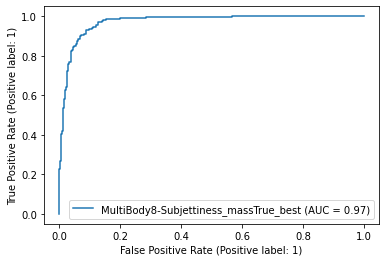

In [149]:
labels = test_labels[:,1].detach().numpy()
preds = model(test_features.cuda())[:,1].cpu().ravel().detach().numpy()
sklearn.metrics.RocCurveDisplay.from_predictions(labels, preds, name='MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_'+ model_type)
plt.show()